In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
medical_records = pd.read_csv(r"C:\Users\DELL\Downloads\medical_records.csv")

In [8]:
path = "/content/drive/MyDrive/T5camp/medical_records.csv"
medical_records = pd.read_csv(path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/T5camp/medical_records.csv'

# Define Helper Functions:

In [9]:
def show_outliers_ranges(series):
  '''
  as the name says this function show the min range and the max range for outliers in series.
  params:
  series: the series that will shows its outliers.
  return:
  the min range that will be not consider outlier, and the max range that will be not consider outlier
  '''
  column = series.copy()
  
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  IQR = Q3 - Q1
  
  min_range = Q1 - 1.5 * IQR
  max_range = Q3 + 1.5 * IQR
  
  return min_range, max_range


def clean_outliers(series):
  '''
  this function clean outliers from series
  params:
  series: the series that will clean its outliers.
  return:
  the new series that its outliers replaced with the min range and max range.
  '''
  column = series.copy()
    
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  IQR = Q3 - Q1
  
  min_range = Q1 - 1.5 * IQR
  max_range = Q3 + 1.5 * IQR
  
  min_outliers_mask = column < min_range
  max_outliers_mask = column > max_range
  
  column[min_outliers_mask] = min_range
  column[max_outliers_mask] = max_range
  return column


def simple_barplot(data, figsize=(16,8), rot=0, color=None):
  '''
  this function use to visualize data as bar plot
  params:
  data: the dataframe will plot.
  figsize: plot size.
  rot: the rotation of the x-axis labels.
  color: bars colors.
  return:
  the bar plot
  '''
  p_chart = data.plot.bar(figsize=figsize, rot=rot, color=color)
  for p in p_chart.patches:
    p_chart.annotate(str(p.get_height()), (p.get_x() * 1.05, p.get_height() *1.01))
    
  return p_chart


def our_barplot(data ,target, features, value, rot=0, color=None, inverse_plot=False, aggfunc=np.size, fill_value=0, figsize=(16,8)):
  '''
  this function use to visualize data
  params:
  data: the dataframe
  target: the target column that want to focus.
  features: the features that want to plot the target based on.
  value: the feature that define the unique row.
  rot: the rotation of the x-axis labels.
  color: bars colors.
  inverse_plot: if True, it will inverse the bar plot.
  aggfunc: the aggeragate function that will use on grouping. to plot
  fill_value: the value that will put rather than nan.
  figsize: plot size.
  return:
  the bar plot
  '''
  x_y = [target]
  x_y += features
  x_y += [value]
  
  features_frame = data[x_y]
  if inverse_plot:
    slice_pivot = features_frame.pivot_table(index=[target], columns=features, aggfunc=aggfunc, fill_value=fill_value)
  else:
    slice_pivot = features_frame.pivot_table(index=features, columns=[target], aggfunc=aggfunc, fill_value=fill_value)

  slice_pivot = slice_pivot.droplevel(0, axis=1)
  return simple_barplot(slice_pivot, figsize, rot, color), slice_pivot


def age_group(age):
    if age>=0 and age<=2:
        return 'Baby'
    elif age>2 and age<=12:
        return 'Child'
    elif age>12 and age<=18:
        return 'Young'
    elif age>18 and age<=30:
        return 'Adult'
    elif age>30 and age<=45:
        return 'Mid-age'
    elif age>45 and age<=60:
        return 'Mature'
    else:
        return 'Old'    
  

---
# Investigate The Data:

In [10]:
medical_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


---
## Notes About Data:
- **ScheduledDay:** The day someone called or registered the appointment, this is before appointment of course.
- **AppointmentDay:** The day of the actuall appointment, when they have to visit the doctor.

- **Hipertension:** ارتفاع ضغط الدم
- **Diabetes:** داء السكري
- **Alcoholism:** إدمان الكحول
- **Handcap:** عائق
---

In [11]:
medical_records.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [12]:
pd.options.display.max_rows = 50
medical_records.sample(50)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
74094,3.962527e+14,5707658,M,2016-05-17T09:55:32Z,2016-05-17T00:00:00Z,51,SANTA LUÍZA,0,0,0,0,0,0,No
35810,9.954353e+14,5690622,M,2016-05-12T10:23:07Z,2016-05-19T00:00:00Z,11,DA PENHA,0,0,0,0,0,0,Yes
61189,1.398731e+12,5690216,F,2016-05-12T09:40:43Z,2016-05-25T00:00:00Z,26,GRANDE VITÓRIA,0,0,0,0,0,1,No
68382,1.336493e+13,5719892,M,2016-05-19T12:41:47Z,2016-05-19T00:00:00Z,59,MARIA ORTIZ,0,0,0,0,0,0,No
62905,2.261523e+10,5414881,M,2016-03-01T12:01:31Z,2016-05-18T00:00:00Z,56,JARDIM CAMBURI,0,1,0,0,0,0,No
2289,8.612885e+12,5493135,F,2016-03-21T08:17:53Z,2016-04-29T00:00:00Z,43,BELA VISTA,0,0,0,0,0,1,Yes
86336,6.639752e+13,5707312,F,2016-05-17T09:29:29Z,2016-06-08T00:00:00Z,51,MÁRIO CYPRESTE,0,0,0,0,0,0,No
59180,8.918674e+14,5615853,M,2016-04-25T13:09:32Z,2016-05-03T00:00:00Z,35,SANTA TEREZA,0,1,0,0,0,1,No
57295,2.428928e+13,5579925,M,2016-04-13T15:57:38Z,2016-05-20T00:00:00Z,20,MARIA ORTIZ,0,0,0,0,0,0,Yes
32421,3.648558e+14,5645258,F,2016-05-02T09:40:12Z,2016-05-19T00:00:00Z,67,DO MOSCOSO,0,1,0,0,0,0,No


In [13]:
medical_records['Neighbourhood'].value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

---
## What Has Been Noticed:
- Dataset in Brazil
- patientId & AppointmentID: maybe not useful
- Gender: Female more than male
- ScheduledDay & AppointmentDay: are object(string)
- age: min=-1, max=115
- Neighbourhood: 81 unique value
- No-show: its type object(string), target
---

---
# Cleaning Data:

In [14]:
cleaned_records = medical_records.copy()
cleaned_records

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [15]:
new_values = {'M': 1, 'F': 0}

# Male = 1, Female = 0
cleaned_records['Gender'] = cleaned_records['Gender'].map(new_values)

In [16]:
cleaned_records

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,0,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,0,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,0,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,0,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [17]:
# convert object to datetime.
cleaned_records['ScheduledDay'] = cleaned_records['ScheduledDay'].astype('datetime64')
cleaned_records['AppointmentDay'] = cleaned_records['AppointmentDay'].astype('datetime64')

In [18]:
cleaned_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110527 non-null  float64       
 1   AppointmentID   110527 non-null  int64         
 2   Gender          110527 non-null  int64         
 3   ScheduledDay    110527 non-null  datetime64[ns]
 4   AppointmentDay  110527 non-null  datetime64[ns]
 5   Age             110527 non-null  int64         
 6   Neighbourhood   110527 non-null  object        
 7   Scholarship     110527 non-null  int64         
 8   Hipertension    110527 non-null  int64         
 9   Diabetes        110527 non-null  int64         
 10  Alcoholism      110527 non-null  int64         
 11  Handcap         110527 non-null  int64         
 12  SMS_received    110527 non-null  int64         
 13  No-show         110527 non-null  object        
dtypes: datetime64[ns](2), float64(1), in

In [19]:
# cheack the patients who thiers age under 5 and shows.
zero_mask = (cleaned_records['Age'] <= 5) & (cleaned_records['No-show'] == 'Yes')
cleaned_records[zero_mask]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
21,1.215484e+13,5628338,0,2016-04-27 10:50:45,2016-04-29,4,CONQUISTA,0,0,0,0,0,0,Yes
61,5.594636e+11,5626971,0,2016-04-27 08:53:09,2016-04-29,2,NOVA PALESTINA,0,0,0,0,0,0,Yes
104,3.326985e+12,5632495,0,2016-04-28 08:04:48,2016-04-29,0,SANTO ANTÔNIO,0,0,0,0,0,0,Yes
132,8.468587e+14,5560742,1,2016-04-08 09:29:23,2016-04-29,0,PRAIA DO SUÁ,0,0,0,0,0,1,Yes
184,7.569883e+12,5520853,0,2016-03-29 10:37:48,2016-04-29,3,NOVA PALESTINA,0,0,0,0,0,1,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110323,6.489387e+14,5603103,0,2016-04-19 16:44:16,2016-06-08,3,RESISTÊNCIA,0,0,0,0,0,1,Yes
110331,2.739486e+13,5392089,0,2016-02-24 15:33:08,2016-06-01,0,RESISTÊNCIA,0,0,0,0,0,1,Yes
110332,7.921133e+11,5603681,0,2016-04-20 07:17:43,2016-06-08,4,RESISTÊNCIA,0,0,0,0,0,1,Yes
110339,3.731746e+12,5584042,1,2016-04-14 13:01:21,2016-06-01,0,RESISTÊNCIA,0,0,0,0,0,1,Yes


In [20]:
# drop the row with age = -1
mines_mask = cleaned_records['Age'] == -1
mines_index = cleaned_records[mines_mask].index[0]

cleaned_records.drop(mines_index, inplace=True)
cleaned_records

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,0,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,1,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,0,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,0,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,0,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,0,2016-05-03 09:15:35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,0,2016-05-03 07:27:33,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,0,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,0,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [21]:
# check patients who thiers age above or equal 100
hund_mask = cleaned_records['Age'] >= 100
cleaned_records[hund_mask]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
58014,9.762948e+14,5651757,0,2016-05-03 09:14:53,2016-05-03,102,CONQUISTA,0,0,0,0,0,0,No
63912,3.196321e+13,5700278,0,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,0,2016-05-16 09:17:44,2016-05-19,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,0,2016-04-08 14:29:17,2016-05-16,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,0,2016-05-30 09:44:51,2016-05-30,115,ANDORINHAS,0,0,0,0,1,0,No
79270,9.739430e+12,5747809,1,2016-05-30 16:21:56,2016-05-31,100,TABUAZEIRO,0,0,0,0,1,0,No
79272,9.739430e+12,5747808,1,2016-05-30 16:21:56,2016-05-31,100,TABUAZEIRO,0,0,0,0,1,0,No
90372,2.342836e+11,5751563,0,2016-05-31 10:19:49,2016-06-02,102,MARIA ORTIZ,0,0,0,0,0,0,No
92084,5.578313e+13,5670914,0,2016-05-06 14:55:36,2016-06-03,100,ANTÔNIO HONÓRIO,0,0,0,0,0,1,No
97666,7.482346e+14,5717451,0,2016-05-19 07:57:56,2016-06-03,115,SÃO JOSÉ,0,1,0,0,0,1,No


In [22]:
# refactor no-show feature.
new_values = {'No': 1, 'Yes': 0}

# 1: show, 0: no-show
cleaned_records['No-show'] = cleaned_records['No-show'].map(new_values)
cleaned_records.rename(columns={'No-show': 'show'}, inplace=True)

cleaned_records.head(10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show
0,2.987250e+13,5642903,0,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,5.589978e+14,5642503,1,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4.262962e+12,5642549,0,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,8.679512e+11,5642828,0,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8.841186e+12,5642494,0,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1
5,9.598513e+13,5626772,0,2016-04-27 08:36:51,2016-04-29,76,REPÚBLICA,0,1,0,0,0,0,1
6,7.336882e+14,5630279,0,2016-04-27 15:05:12,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,0
7,3.449833e+12,5630575,0,2016-04-27 15:39:58,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0,0
8,5.639473e+13,5638447,0,2016-04-29 08:02:16,2016-04-29,21,ANDORINHAS,0,0,0,0,0,0,1
9,7.812456e+13,5629123,0,2016-04-27 12:48:25,2016-04-29,19,CONQUISTA,0,0,0,0,0,0,1


---

In [23]:
# convert patientId to integer.
cleaned_records['PatientId'] = cleaned_records['PatientId'].astype('int64')
cleaned_records

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show
0,29872499824296,5642903,0,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1
1,558997776694438,5642503,1,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1
2,4262962299951,5642549,0,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1
3,867951213174,5642828,0,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1
4,8841186448183,5642494,0,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,5651768,0,2016-05-03 09:15:35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,1
110523,3596266328735,5650093,0,2016-05-03 07:27:33,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,1
110524,15576631729893,5630692,0,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,1
110525,92134931435557,5630323,0,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,1


In [24]:
# check types
cleaned_records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PatientId       110526 non-null  int64         
 1   AppointmentID   110526 non-null  int64         
 2   Gender          110526 non-null  int64         
 3   ScheduledDay    110526 non-null  datetime64[ns]
 4   AppointmentDay  110526 non-null  datetime64[ns]
 5   Age             110526 non-null  int64         
 6   Neighbourhood   110526 non-null  object        
 7   Scholarship     110526 non-null  int64         
 8   Hipertension    110526 non-null  int64         
 9   Diabetes        110526 non-null  int64         
 10  Alcoholism      110526 non-null  int64         
 11  Handcap         110526 non-null  int64         
 12  SMS_received    110526 non-null  int64         
 13  show            110526 non-null  int64         
dtypes: datetime64[ns](2), int64(11), obj

In [25]:
# check if the patientId is unique and not duplicated.
cleaned_records['PatientId'].unique

<bound method Series.unique of 0          29872499824296
1         558997776694438
2           4262962299951
3            867951213174
4           8841186448183
               ...       
110522      2572134369293
110523      3596266328735
110524     15576631729893
110525     92134931435557
110526    377511518121127
Name: PatientId, Length: 110526, dtype: int64>

In [26]:
#drop AppointmentID
cleaned_records.drop(columns=['AppointmentID'],inplace=True)

### create new columns
1. **sameday**
> to see if the patient has booking an appointment and attend on the same day will he/she attend?
2. **sameweek**
> to see if the patient has booking an appointment and attend on the same week will he/she attend?
3. **samemonth**
> to see if the patient has booking an appointment and attend on the same month will he/she attend?

In [27]:
# first we need to delete time ftom ScheduledDay column
cleaned_records['ScheduledDay'] = pd.to_datetime(cleaned_records['ScheduledDay']).dt.date
# then pandas well transform Scheduled Day to object and we are well change it to date
cleaned_records['ScheduledDay'] = cleaned_records['ScheduledDay'].astype('datetime64')

#### sameday

In [28]:
# create new columns (appointment_time) that contain the difference days between ScheduledDay and AppointmentDay
cleaned_records['appointment_time'] = cleaned_records['AppointmentDay'] - cleaned_records['ScheduledDay']
cleaned_records

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show,appointment_time
0,29872499824296,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0 days
1,558997776694438,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0 days
2,4262962299951,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0 days
3,867951213174,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0 days
4,8841186448183,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,0,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,1,35 days
110523,3596266328735,0,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,1,35 days
110524,15576631729893,0,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,1,41 days
110525,92134931435557,0,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,1,41 days


In [29]:
# just take num of days from column and changeit to int
cleaned_records['appointment_time'] = cleaned_records['appointment_time'].dt.days

In [30]:
# change value to 0 - 1
# 1 = sameday
# 0 = not sameday 
cleaned_records['sameday'] = 0
sameday_mask = cleaned_records['appointment_time'] == 0
cleaned_records.loc[sameday_mask, 'sameday'] = 1
cleaned_records

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show,appointment_time,sameday
0,29872499824296,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0,1
1,558997776694438,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0,1
2,4262962299951,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0,1
3,867951213174,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0,1
4,8841186448183,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,0,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,1,35,0
110523,3596266328735,0,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,1,35,0
110524,15576631729893,0,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,1,41,0
110525,92134931435557,0,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,1,41,0


In [31]:
# check if there is wrong value
cleaned_records.sort_values(by='appointment_time',ascending=True).head(10)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show,appointment_time,sameday
71533,998231581612122,0,2016-05-11,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,0,-6,0
72362,3787481966821,1,2016-05-04,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,0,-1,0
64175,24252258389979,0,2016-05-05,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,0,-1,0
55226,7896293967868,0,2016-05-18,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,0,-1,0
27033,7839272661752,1,2016-05-10,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,0,-1,0
57785,63578717945831,1,2016-05-04,2016-05-04,46,NOVA PALESTINA,0,0,0,0,0,0,0,0,1
57786,7758559298974,0,2016-05-18,2016-05-18,48,NOVA PALESTINA,0,0,0,0,0,0,1,0,1
57787,8867812918895,0,2016-05-25,2016-05-25,58,NOVA PALESTINA,0,1,0,0,0,0,1,0,1
57788,399649431646135,1,2016-05-18,2016-05-18,56,NOVA PALESTINA,0,0,1,0,0,0,1,0,1
57789,16371349179368,0,2016-05-25,2016-05-25,47,NOVA PALESTINA,0,0,0,0,0,0,0,0,1


In [32]:
# take index from negative values and drop it
negative_rows = cleaned_records[cleaned_records['appointment_time']<0].index
cleaned_records.drop(labels=negative_rows,axis=0,inplace=True)
cleaned_records.sort_values(by='appointment_time',ascending=True).head(10)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show,appointment_time,sameday
0,29872499824296,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0,1
57785,63578717945831,1,2016-05-04,2016-05-04,46,NOVA PALESTINA,0,0,0,0,0,0,0,0,1
57786,7758559298974,0,2016-05-18,2016-05-18,48,NOVA PALESTINA,0,0,0,0,0,0,1,0,1
57787,8867812918895,0,2016-05-25,2016-05-25,58,NOVA PALESTINA,0,1,0,0,0,0,1,0,1
57788,399649431646135,1,2016-05-18,2016-05-18,56,NOVA PALESTINA,0,0,1,0,0,0,1,0,1
57789,16371349179368,0,2016-05-25,2016-05-25,47,NOVA PALESTINA,0,0,0,0,0,0,0,0,1
57791,548828668484667,0,2016-05-18,2016-05-18,39,NOVA PALESTINA,0,0,0,0,0,0,1,0,1
57817,48872248573417,0,2016-05-03,2016-05-03,58,NOVA PALESTINA,0,1,0,0,0,0,1,0,1
57822,373839949173,0,2016-05-03,2016-05-03,44,NOVA PALESTINA,1,0,1,0,0,0,0,0,1
57832,753356144342564,1,2016-05-17,2016-05-17,78,NOVA PALESTINA,0,1,0,0,0,0,1,0,1


### sameweek

In [33]:
# change value to 0 - 1
# 1 = sameweek
# 0 = not sameweek
cleaned_records['sameweek'] = 0
sameweek_mask = cleaned_records['appointment_time'] <= 7
cleaned_records.loc[sameweek_mask, 'sameweek'] = 1
cleaned_records.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show,appointment_time,sameday,sameweek
0,29872499824296,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0,1,1
1,558997776694438,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0,1,1
2,4262962299951,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0,1,1
3,867951213174,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0,1,1
4,8841186448183,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0,1,1


### samemonth

In [34]:

# change value to 0 - 1
# 1 = samemonth
# 0 = not samemonth
cleaned_records['samemonth'] = 0
samemonth_mask = cleaned_records['appointment_time'] <= 30
cleaned_records.loc[sameweek_mask, 'samemonth'] = 1
cleaned_records.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show,appointment_time,sameday,sameweek,samemonth
0,29872499824296,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0,1,1,1
1,558997776694438,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0,1,1,1
2,4262962299951,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0,1,1,1
3,867951213174,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0,1,1,1
4,8841186448183,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0,1,1,1


---
# Visualization:

#### Labeling:

In [35]:
labeld_records = cleaned_records.copy()
labeld_records

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show,appointment_time,sameday,sameweek,samemonth
0,29872499824296,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0,1,1,1
1,558997776694438,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0,1,1,1
2,4262962299951,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0,1,1,1
3,867951213174,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0,1,1,1
4,8841186448183,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,0,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,1,35,0,0,0
110523,3596266328735,0,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,1,35,0,0,0
110524,15576631729893,0,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,1,41,0,0,0
110525,92134931435557,0,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,1,41,0,0,0


In [36]:
new_values = {1:'Has',0:'Not Has'}
labeld_records['Scholarship']=labeld_records['Scholarship'].map(new_values)

new_values = {1:'Sick',0:'Safe'}
labeld_records['Hipertension']=labeld_records['Hipertension'].map(new_values)

new_values = {1:'Sick',0:'Safe'}
labeld_records['Diabetes']=labeld_records['Diabetes'].map(new_values)

new_values = {1:'Yes',0:'No'}
labeld_records['Alcoholism']=labeld_records['Alcoholism'].map(new_values)

new_values = {1:'received',0:'Not received'}
labeld_records['SMS_received']=labeld_records['SMS_received'].map(new_values)

new_values = {1:'Male',0:'Female'}
labeld_records['Gender']=labeld_records['Gender'].map(new_values)

new_values = {1:'sameday',0:'Not sameday'}
labeld_records['sameday']=labeld_records['sameday'].map(new_values)

new_values = {1:'sameweek',0:'Not sameweek'}
labeld_records['sameweek']=labeld_records['sameweek'].map(new_values)

new_values = {1:'samemonth',0:'Not samemonth'}
labeld_records['samemonth']=labeld_records['samemonth'].map(new_values)

new_values = {1:'Show',0:'Not Show'}
labeld_records['show']=labeld_records['show'].map(new_values)

labeld_records['AppointmentDay'] = pd.to_datetime(labeld_records.AppointmentDay).dt.day_name()

#### One Feature With Target

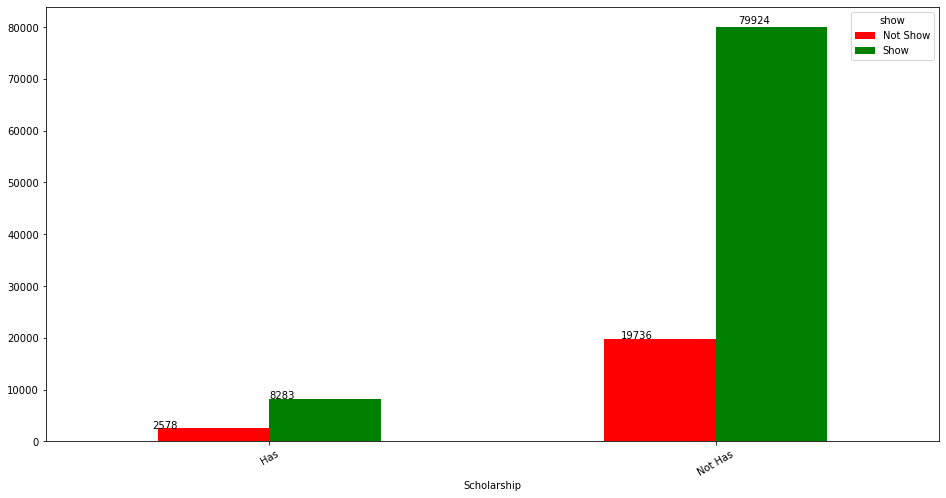

In [37]:
our_barplot(labeld_records, target='show', features=['Scholarship'], value='PatientId', rot=30, color=['red', 'green']);

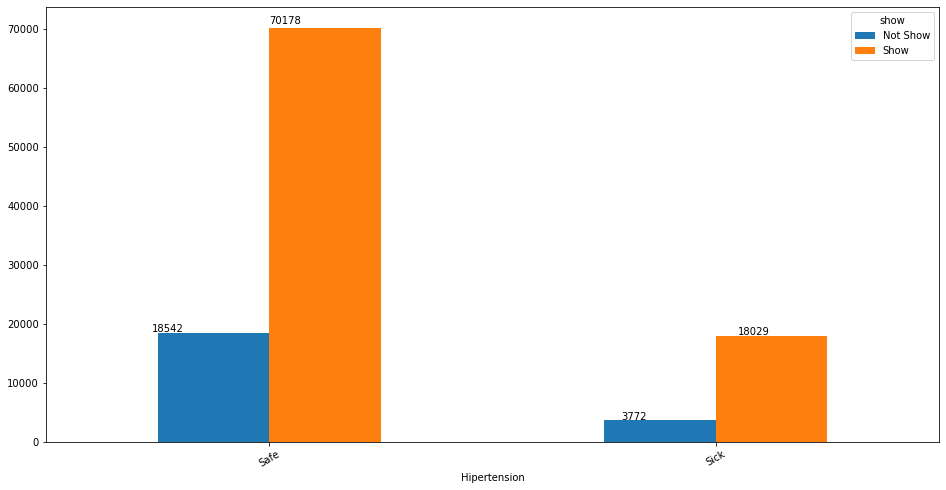

In [38]:
our_barplot(labeld_records, target='show', features=['Hipertension'], value='PatientId', rot=30, color=None);

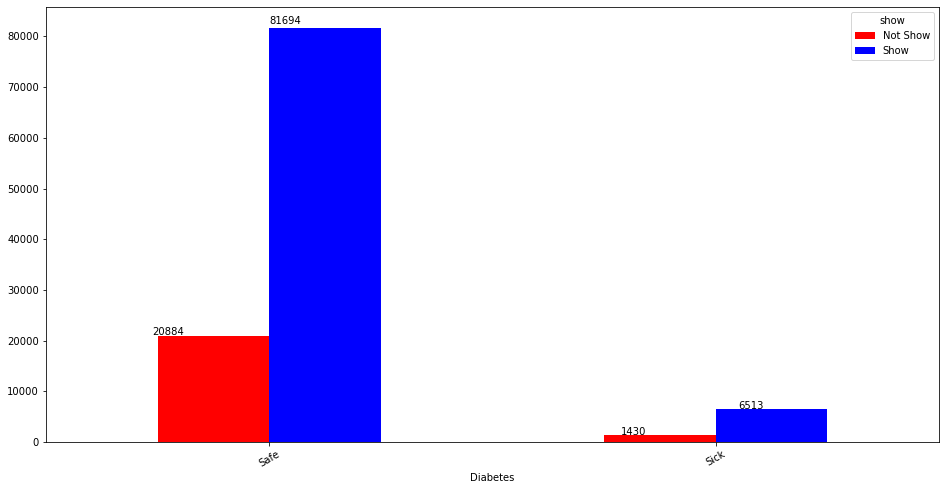

In [39]:
our_barplot(labeld_records, target='show', features=['Diabetes'], value='PatientId', rot=30, color=['red', 'blue']);

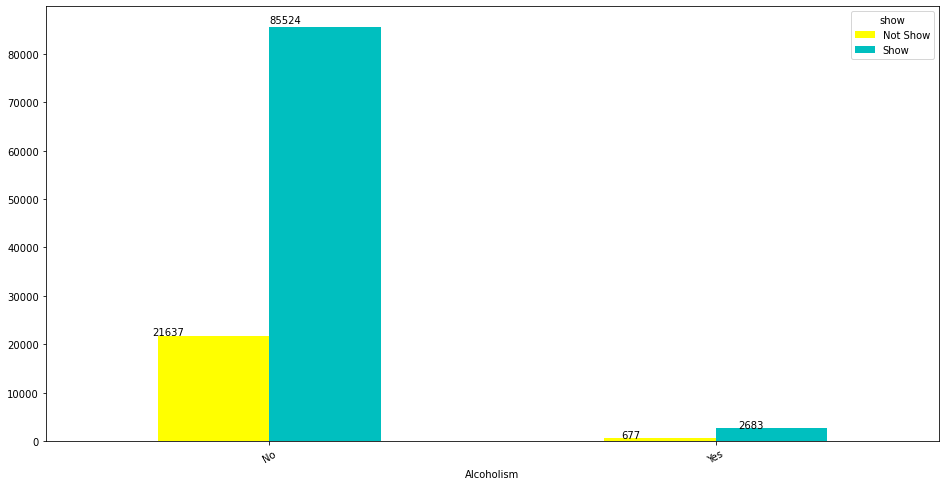

In [40]:
our_barplot(labeld_records, target='show', features=['Alcoholism'], value='PatientId', rot=30, color=['yellow', 'c']);

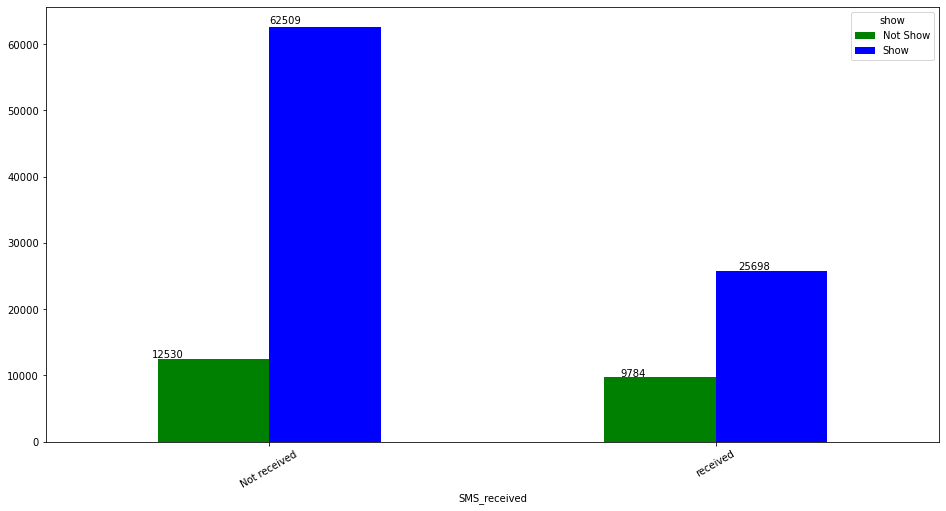

In [41]:
our_barplot(labeld_records, target='show', features=['SMS_received'], value='PatientId', rot=30, color=['green', 'blue']);

## Questions

### Q1: Percentage no-show

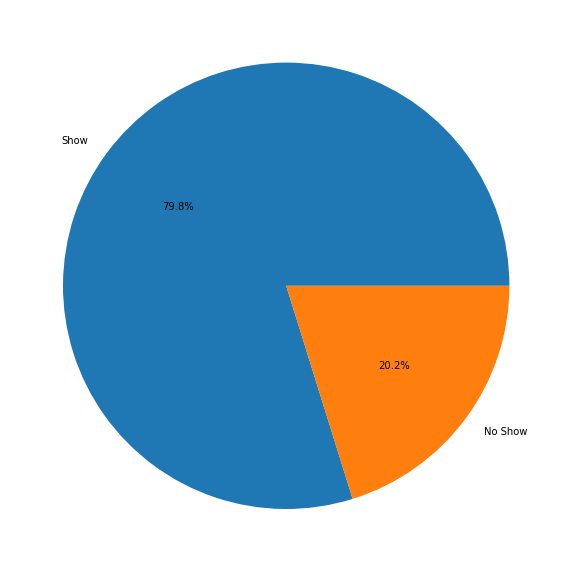

In [42]:
fig = plt.figure(figsize=(10,15))
labels = ['Show','No Show']
plt.pie(cleaned_records['show'].value_counts(),labels=labels,autopct='%1.1f%%')

plt.show()

### Q2: Does the age group affect the number of attendees?

In [43]:
cleaned_records['age_group'] = cleaned_records['Age'].apply(age_group)
labeld_records['age_group'] = labeld_records['Age'].apply(age_group)

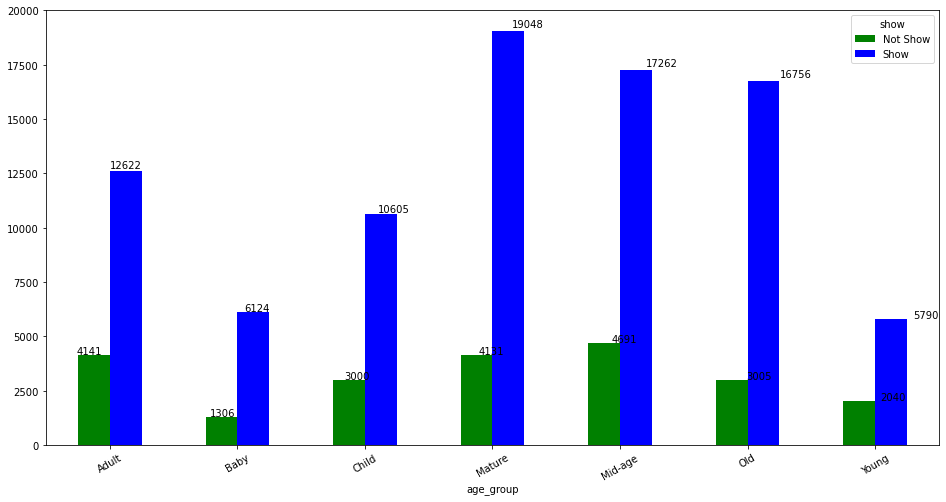

In [44]:
our_barplot(labeld_records, target='show', features=['age_group'], value='PatientId', rot=30, color=['green', 'blue']);

### Q3: Is the percentage of people with special needs large?

In [45]:
cleaned_records['Is_Handcap'] = 0
Handcap_mask = cleaned_records['Handcap'] > 0
cleaned_records.loc[Handcap_mask, 'Is_Handcap'] = 1
cleaned_records

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show,appointment_time,sameday,sameweek,samemonth,age_group,Is_Handcap
0,29872499824296,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0,1,1,1,Old,0
1,558997776694438,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0,1,1,1,Mature,0
2,4262962299951,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0,1,1,1,Old,0
3,867951213174,0,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1,0,1,1,1,Child,0
4,8841186448183,0,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,1,0,1,1,1,Mature,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2572134369293,0,2016-05-03,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,1,35,0,0,0,Mature,0
110523,3596266328735,0,2016-05-03,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,1,35,0,0,0,Mature,0
110524,15576631729893,0,2016-04-27,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,1,41,0,0,0,Adult,0
110525,92134931435557,0,2016-04-27,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,1,41,0,0,0,Mid-age,0


In [46]:
cleaned_records['Is_Handcap'].value_counts()

0    108282
1      2239
Name: Is_Handcap, dtype: int64

In [47]:
cleaned_records['Handcap'].value_counts()

0    108282
1      2040
2       183
3        13
4         3
Name: Handcap, dtype: int64

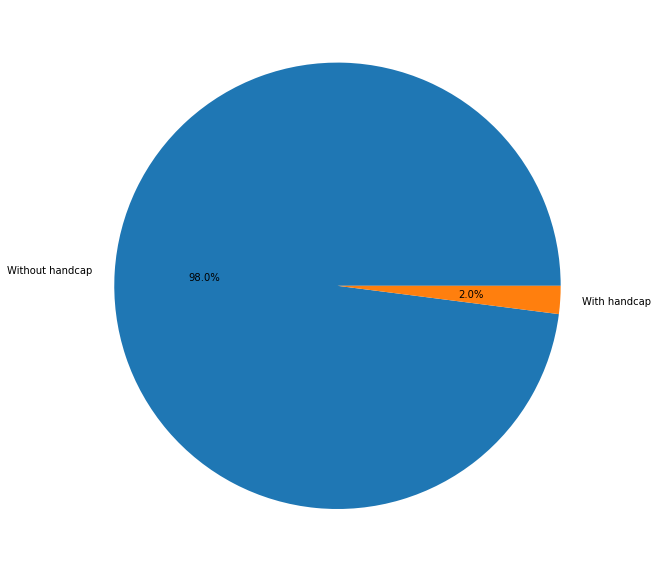

In [48]:
fig = plt.figure(figsize =(10, 15))
labels = ['Without handcap','With handcap']
plt.pie(cleaned_records['Is_Handcap'].value_counts(),labels=labels,autopct='%1.1f%%')
 
# show plot
plt.show()

### Q4:Do text messages affect the number of attendees? Or are there alternatives?

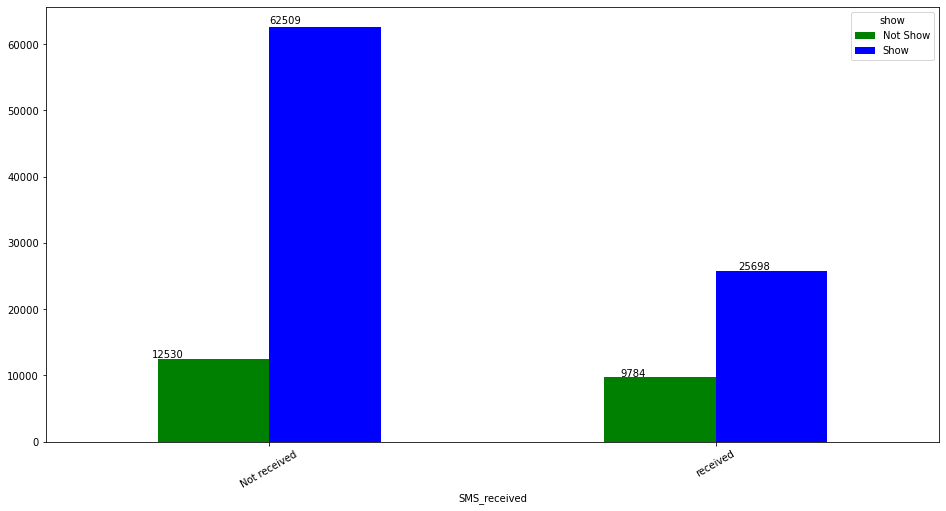

In [49]:
our_barplot(labeld_records, target='show', features=['SMS_received'], value='PatientId', rot=30, color=['green', 'blue']);

### Q5: Does the waiting time for the appointment have an effect on the attendance 

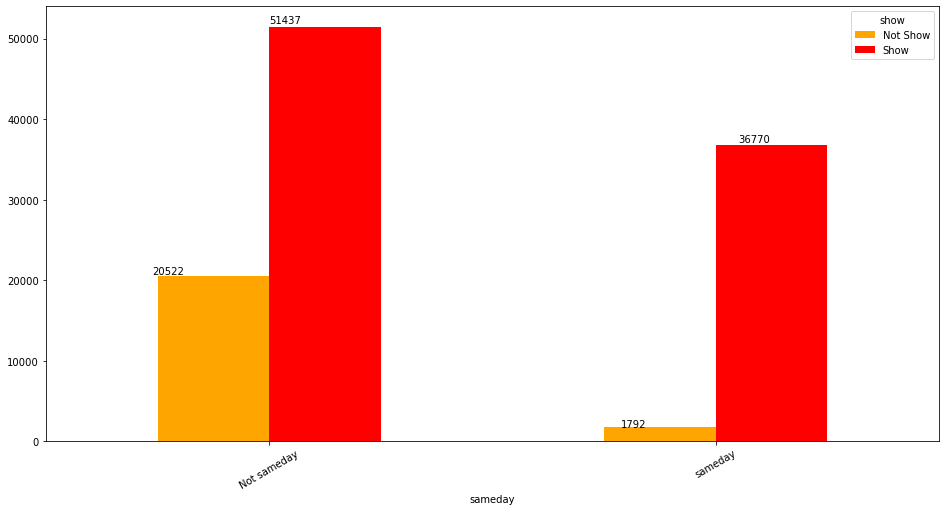

In [50]:
our_barplot(labeld_records, target='show', features=['sameday'], value='PatientId', rot=30, color=['orange', 'red']);

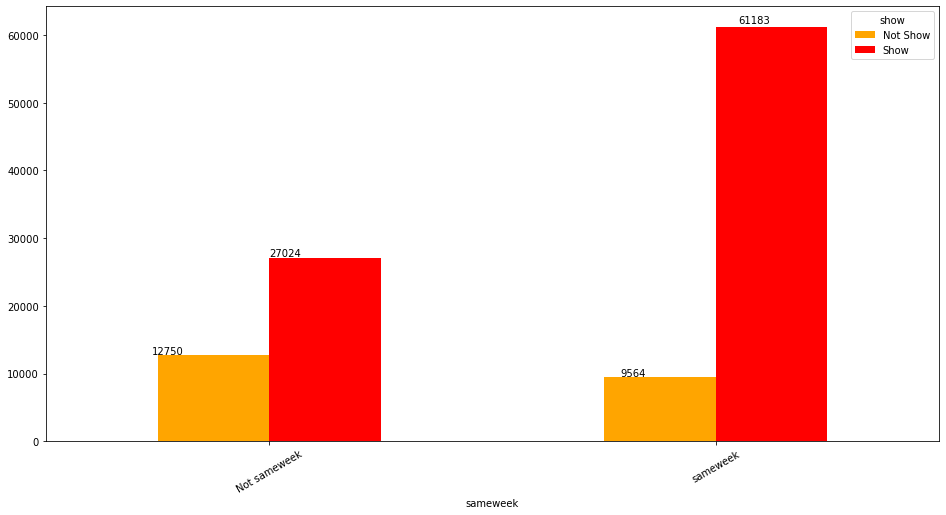

In [51]:
our_barplot(labeld_records, target='show', features=['sameweek'], value='PatientId', rot=30, color=['orange', 'red']);

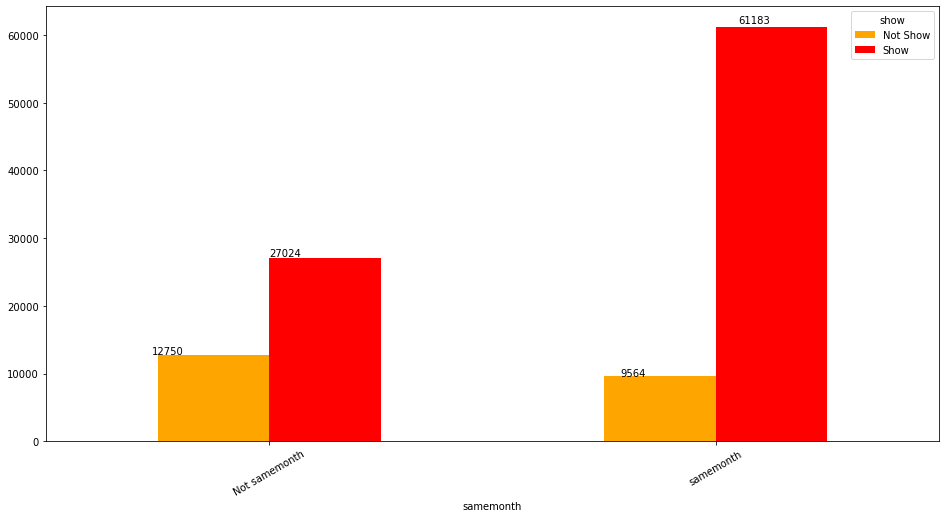

In [52]:
our_barplot(labeld_records, target='show', features=['samemonth'], value='PatientId', rot=30, color=['orange', 'red']);

### Q6: What are the busiest days in the hospital?

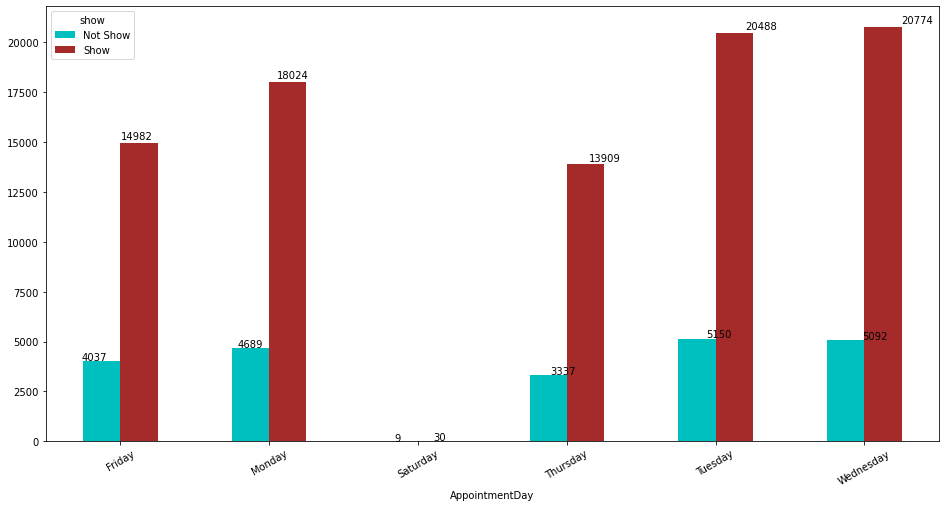

In [53]:
bar, app_by_days = our_barplot(labeld_records, target='show', features=['AppointmentDay'], value='PatientId', rot=30, color=['c', 'brown']);

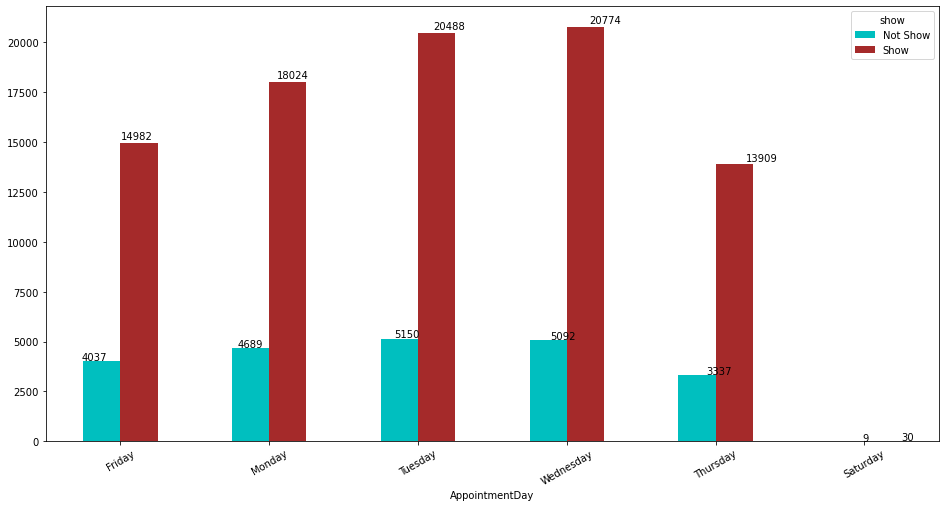

In [54]:
# Order days then plot again
ordered_days = app_by_days.copy()
ordered_days.drop(index=['Friday', 'Monday', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday'], inplace=True)

ordered_days.loc['Friday'] = app_by_days.loc['Friday']
ordered_days.loc['Monday'] = app_by_days.loc['Monday']
ordered_days.loc['Tuesday'] = app_by_days.loc['Tuesday']
ordered_days.loc['Wednesday'] = app_by_days.loc['Wednesday']
ordered_days.loc['Thursday'] = app_by_days.loc['Thursday']
ordered_days.loc['Saturday'] = app_by_days.loc['Saturday']

simple_barplot(ordered_days, rot=30, color=['c', 'brown']);

### Q7: What are the busiest days in the hospital?

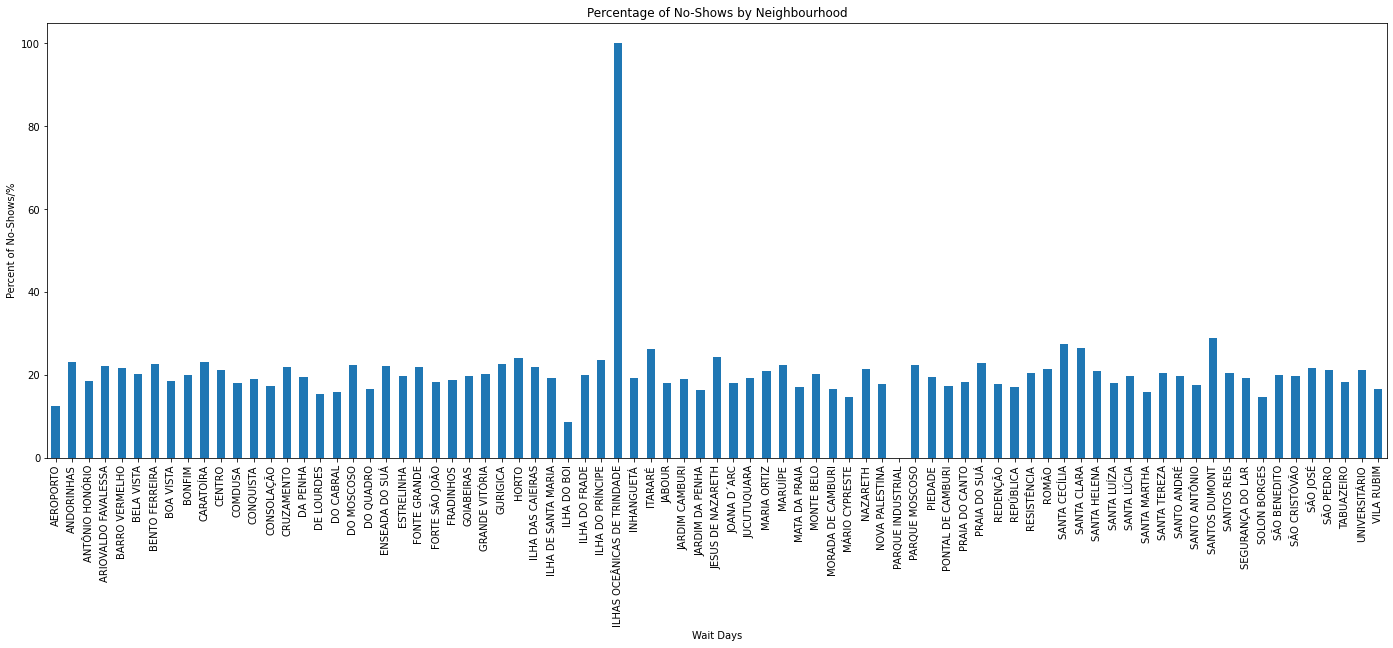

In [55]:
def no_show_percentage(data, column):

    #no show count by column
    no_show = data[data["show"]=="Not Show"].groupby(column).count()["PatientId"]
    #all count by column
    all_appoint = data.groupby(column).count()["PatientId"]
    #percentage of no-shows by column
    month_percent = (no_show/all_appoint)*100

    return month_percent

plt.figure(figsize=(24,8))
ax10 = no_show_percentage(data=labeld_records,column="Neighbourhood").plot(kind='bar')
ax10 = plt.gca()
ax10.set_title("Percentage of No-Shows by Neighbourhood")
ax10.set_ylabel("Percent of No-Shows/%")
ax10.set_xlabel("Wait Days")
ax10.tick_params(axis='x', labelrotation = 90)
plt.show()